# 四种天气图片的分类和卷积神经网络

## 过拟合

训练一个卷积神经网络，用于对四种天气图片进行分类：阴天（cloudy）、雨天（rain）、晴天（shine）、日出（sunrise）

**模型结构：** 卷积层->池化层->卷积层->池化层->全连接层->全连接层->输出层 *（此时产生过拟合，训练集准确率100%，测试集准确率只有91%）*

**过拟合：** 模型在训练集上表现良好，但在测试集上表现较差，即模型在训练集上过拟合了，无法泛化到新的数据上

**过拟合的解决方法：**
1. 数据增强：增加训练集的数量，如旋转、翻转、裁剪等操作
2. 正则化：在损失函数中添加正则项，如L1、L2正则化
3. Dropout：在训练过程中随机丢弃一部分神经元，防止神经元之间的相互依赖
4. 模型简化：减少模型层数或神经元数量

本例中使用Dropout来优化过拟合：Dropout是一种常用的防止过拟合的方法，它通过在训练过程中随机丢弃一部分神经元，使得模型在训练过程中不会过度依赖某些神经元，从而提高模型的泛化能力。相当于在训练过程中使用了多棵不同的决策树，通过投票的方式决定最终的分类结果，从而提高模型的准确率。在测试时，Dropout不发挥作用，因为此时需要使用所有的神经元来得到最好的预测结果。



## 批标准化（Batch Normalization）

**标准化：** 将数据减去其均值，使其中心为0，然后除以其标准差，使其方差为1。

**归一化：** 将数据缩放到一个固定的范围，如0到1之间（ToTenser方法），或者-1到1之间。

标准化和归一化都可以将数据缩放到一个固定的范围，但是标准化后的数据具有0均值和1方差，而归一化后的数据具有固定的最小值和最大值。在训练神经网络时，标准化和归一化都可以提高模型的收敛速度和稳定性。

**梯度消失：** 以sigmoid函数为例，sigmoid函数将输入映射到(0,1)之间，当输入较大或较小时，sigmoid函数的导数接近于0，导致梯度消失。梯度消失使得模型难以训练，因为梯度太小，无法更新模型的参数。

**批标准化（Batch Normalization）** 是一种常用的深度学习技巧，它通过在训练过程中对每一批数据进行标准化（不仅在将数据输入模型之前对数据标准化，而且在网络的每一次变换后都考虑数据标准化），使得每一批数据的均值和方差都接近于0和1，从而提高模型的收敛速度和稳定性。  
* 在测试时，批标准化不发挥作用，因为此时需要使用所有的数据来得到最好的预测结果。  
* 批标准化解决了深度神经网络中梯度消失和梯度爆炸的问题，是一种训练优化方法，使得模型更容易训练和收敛。  
* 批标准化具有正则化的效果，提高模型的泛化能力，允许模型在训练过程中使用更大的学习率，从而提高模型的性能。
* 有助于梯度传播，因此允许更深的网络，对于有一些特别深的网络，只有包含多个BN层的网络才能训练。
* Batch Normalization广泛用于Pytorch内置的神经网络架构中，如ResNet、Inception V3、DenseNet等。
* Batch Normalization层通常应用于卷积层和全连接层之后，但也可以应用于激活函数之后。

**批标准化的实现过程：**
1. 计算每一批数据的均值和方差
2. 对每一批数据进行标准化（减去均值，除以标准差）
3. 训练拉伸参数（scale parameter）γ和偏移参数（shift parameter）β
4. 输出y通过γ和β进行拉伸和偏移的线性变换得到原来的数值
*在训练的正向传播中，不会改变当前的输出，只会记录下当前的γ和β；在反向传播的时候，根据记录的γ和β通过链式求导的方式，求出学习速率以致改变权值*

**批标准化的预测过程：**
对于预测阶段所使用的均值和方差，通常使用训练阶段所有批次的均值和方差，或者使用移动平均的方法计算均值和方差。

**批标准化在model.train()和model.eval()中的区别：**
训练模式下，Batch Normalization会使用当前batch的均值和方差进行标准化，并且会更新moving_mean和moving_var。
测试模式下，Batch Normalization会使用训练阶段计算得到的moving_mean和moving_var进行标准化，不会更新moving_mean和moving_var。

**批标准化的使用位置：**
对于全连接层，通常将Batch Normalization放在全连接层中的仿射变换和激活函数之间；对于卷积层，通常将Batch Normalization放在卷积层和非线性激活函数之间。

## 引入所需库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import os
import shutil

## 划分数据集
将数据集图片按照类别划分到不同的文件夹中

In [2]:
# torchvision.datasets.ImageFolder    ImageFolder类用于读取图片数据集，它假设所有的图片按照类别放在不同的文件夹中，每个文件夹的名字就是类别的名字
# 创建数据集文件夹划分后的训练集和测试集文件夹
base_dir = r'./dataset/4weather' # 数据集的根目录
specises = ['cloudy', 'rain', 'shine', 'sunrise']       # 数据集的类别
train_dir = os.path.join(base_dir, 'train')     # 训练集的文件夹
test_dir = os.path.join(base_dir, 'test')       # 测试集的文件夹
if not os.path.isdir(base_dir):     # 判断文件夹是否存在
    os.mkdir(base_dir)              # 创建文件夹
    os.mkdir(train_dir)             # 创建训练集文件夹
    os.mkdir(test_dir)              # 创建测试集文件夹

    # 分别在训练集和测试集中创建类别文件夹
    for train_or_test in ['train', 'test']:
        for spec in specises:
            os.mkdir(os.path.join(base_dir, train_or_test, spec))

In [3]:
# 将数据集的图片复制到对应的类别文件夹中
image_dir = r'./dataset/Weather'        # 数据集图片的原始存放文件夹

for i, img in enumerate(os.listdir(image_dir)):     # listdir()返回指定路径下的文件和文件夹列表， enumerate()函数返回可枚举对象
    for spec in specises:           # 遍历类别
        if spec in img:             # 判断图片名中是否包含类别名
            s = os.path.join(image_dir, img)    # 拼接图片路径
            if i%5 == 0:
                d = os.path.join(base_dir, 'test', spec, img)
            else:
                d = os.path.join(base_dir, 'train', spec, img)
            shutil.copy(s, d)       # 复制图片

# 查看训练集和测试集的图片数量
for train_or_test in ['train', 'test']:
    for spec in specises:
        print(train_or_test, spec, len(os.listdir(os.path.join(base_dir, train_or_test, spec))))

train cloudy 240
train rain 172
train shine 202
train sunrise 286
test cloudy 60
test rain 43
test shine 51
test sunrise 71


## 读取图片

In [4]:
from torchvision import transforms
transform = transforms.Compose([
                  transforms.Resize((96, 96)),                  # 将图片缩放到96*96
                  transforms.ToTensor(),                        # 将图片转换为张量
                  transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                       std=[0.5, 0.5, 0.5])     # 将图片的每个通道的像素值减去均值，再除以标准差，使像素值均值为0，标准差为1
])

In [5]:
# 读取训练集和测试集的图片
train_ds = torchvision.datasets.ImageFolder(
               train_dir,
               transform=transform
)
test_ds = torchvision.datasets.ImageFolder(
               test_dir,
               transform=transform
)

In [6]:
print(train_ds.classes)            # 查看训练集和测试集的类别
print(train_ds.class_to_idx)       # 查看训练集和测试集的类别索引
print(len(train_ds), len(test_ds)) # 查看训练集和测试集的图片数量

['cloudy', 'rain', 'shine', 'sunrise']
{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}
900 225


## 加载和查看数据

In [7]:
# 加载数据集，划分批次
BATCHSIZE = 16
train_dl = torch.utils.data.DataLoader(
                                       train_ds,
                                       batch_size=BATCHSIZE,
                                       shuffle=True
)
test_dl = torch.utils.data.DataLoader(
                                       test_ds,
                                       batch_size=BATCHSIZE,
)

In [8]:
# 查看数据集的第一批次图片
imgs, labels = next(iter(train_dl))     # 取出训练集的第一批次图片和标签
print(imgs.shape)                       # 查看第一批次图片的形状
print(imgs[0].shape)                    # 查看第一张图片的形状
im = imgs[0].permute(1, 2, 0)           # 将第一张图片的通道维度放到最后
print(im.shape)                         # 查看更改维度后第一张图片的形状
im = im.numpy()                         # 将第一张图片转换为numpy数组
print(type(im))                         # 查看第一张图片的类型
print(im.shape)                         # 查看转换为numpy数组后第一张图片的形状
im = (im + 1)/2                         # 将第一张图片的像素值从[-1, 1]映射到[0, 1]
print(im.max(), im.min())               # 查看第一张图片的像素值范围

torch.Size([16, 3, 96, 96])
torch.Size([3, 96, 96])
torch.Size([96, 96, 3])
<class 'numpy.ndarray'>
(96, 96, 3)
1.0 0.0


{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}
tensor(3)


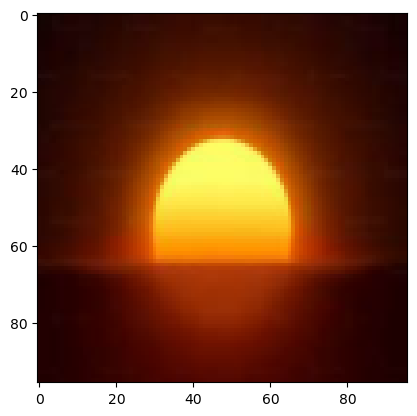

In [9]:
id_to_class = dict((v, k) for k, v in train_ds.class_to_idx.items())        # 将类别索引转换为索引类别
print(id_to_class)
print(labels[0])             # 查看第一张图片的标签
plt.imshow(im)               # 显示第一张图片

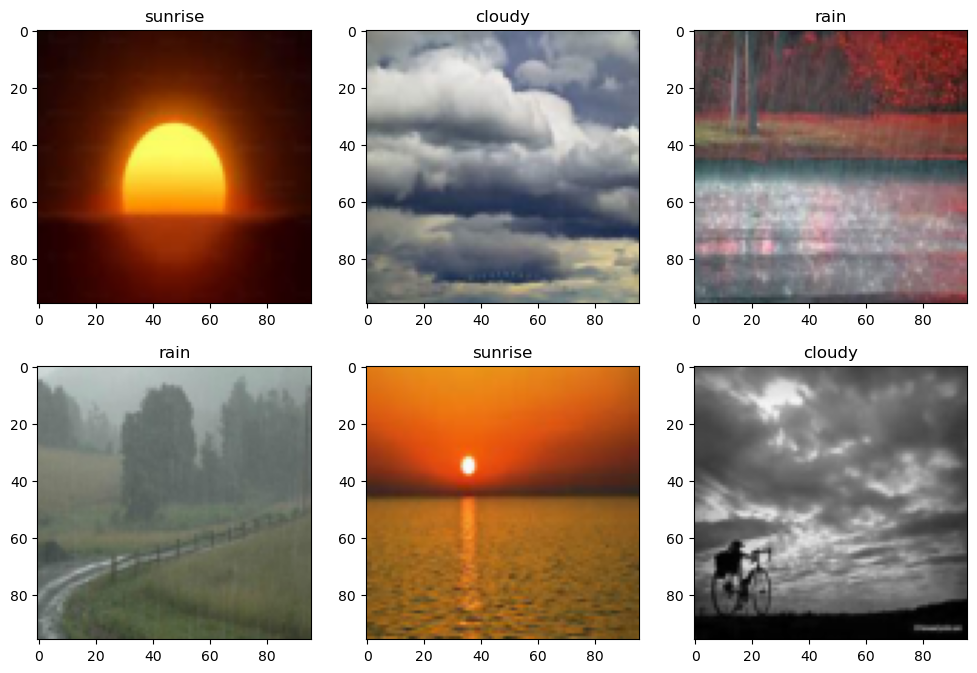

In [10]:
# 查看数据集的前6张图片
plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(imgs[:6], labels[:6])):        # zip()函数将两个列表打包成元组列表
    img = (img.permute(1, 2, 0).numpy() + 1)/2                      # 将图片的通道维度放到最后，将像素值从[-1, 1]映射到[0, 1]
    plt.subplot(2, 3, i+1)                                          # 创建子图
    plt.title(id_to_class.get(label.item()))                        # 设置子图的标题为图片的类别名称
    plt.imshow(img)                                                 # 显示图片

## 构建模型

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout(0.3)                       # 在linker层之间添加dropout层：随机丢弃30%的神经元，防止过拟合
        self.fc1 = nn.Linear(64*10*10, 1024)              # 64*10*10
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        # print(x.size())     # [batch, channel, hight, width]   [16, 64, 10, 10]
        x = x.view(-1, 64*10*10)       # 64*10*10
        x = F.relu(self.fc1(x))
        x = self.drop(x)            # linear层之间添加dropout层
        x = F.relu(self.fc2(x))
        x = self.drop(x)            # linear层之间添加dropout层
        x = self.fc3(x)
        return x
        

In [12]:
# 训练前测试模型
model = Model()           # 初始化模型
preds = model(imgs)     # 使用模型对第一批次图片进行预测，同时获取展平前的中间参数
print(imgs.shape)       # [batch, channel, hight, width]   [16, 3, 32, 32]
print(preds.shape)      # [batch, num_classes]   [16, 4]
torch.argmax(preds, 1)  # 获取预测结果中概率最大的类别索引

torch.Size([16, 3, 96, 96])
torch.Size([16, 4])


tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

## 训练模型

In [ ]:
# 训练前准备，定义模型、损失函数、优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model.to(device) # 将已实例化的模型移动到GPU上

loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数，交叉熵损失函数，使用未激活的输出作为输入，内置了softmax函数为激活函数，输出为每个类别的概率
opt = torch.optim.Adam(model.parameters(), lr=0.001) # 优化器，Adam优化器，学习率为0.001
epochs = 20

# 通用训练模板，输入模型、训练数据、测试数据，返回loss和acc变化
# 训练函数
def train(train_dl, model, loss_fn, opt):
    size = len(train_dl.dataset) # 获取数据集的大小
    num_batches = len(train_dl) # 获取数据集的批次数量

    train_loss = 0.0 # 训练集损失
    train_acc = 0.0 # 训练集准确率

    for x, y in train_dl: # 遍历数据集
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上

        pred = model(x) # 前向传播
        loss = loss_fn(pred, y) # 计算损失

        opt.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        opt.step() # 更新参数

        with torch.no_grad(): # 不计算梯度
            train_loss += loss.item() # 计算损失
            train_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    train_loss /= num_batches # 计算平均损失
    train_acc /= size # 计算平均准确率

    return train_loss, train_acc

# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset) # 获取数据集的大小
    num_batches = len(test_dl) # 获取数据集的批次数量

    test_loss = 0.0 # 测试集损失
    test_acc = 0.0 # 测试集准确率

    with torch.no_grad(): # 不计算梯度
        for x, y in test_dl: # 遍历数据集
            x, y = x.to(device), y.to(device) # 将数据移动到GPU上

            pred = model(x) # 前向传播
            loss = loss_fn(pred, y) # 计算损失
            test_loss += loss.item() # 计算损失
            test_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    test_loss /= num_batches # 计算平均损失
    test_acc /= size # 计算平均准确率

    return test_loss, test_acc

# 训练函数
def fit(epochs, model, train_dl, test_dl, loss_fn, opt):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    print_template = 'Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'


    for epoch in range(epochs):
        model.train() # 设置模型为训练模式，启用dropout层
        epoch_train_loss, epoch_train_acc = train(train_dl, model, loss_fn, opt)
        model.eval() # 设置模型为评估预测模式，禁用dropout层
        epoch_test_loss, epoch_test_acc = test(test_dl, model, loss_fn)

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        print(print_template.format(epoch, epoch_train_loss, epoch_train_acc * 100, epoch_test_loss, epoch_test_acc * 100))

    return train_loss, train_acc, test_loss, test_acc

# 训练
train_loss, train_acc, test_loss, test_acc = fit(epochs, model, train_dl, test_dl, loss_fn, opt)

Epoch: 0, Train Loss: 0.9208, Train Acc: 55.33%, Test Loss: 0.7862, Test Acc: 83.11%
Epoch: 1, Train Loss: 0.5398, Train Acc: 77.56%, Test Loss: 0.7109, Test Acc: 77.78%
Epoch: 2, Train Loss: 0.4626, Train Acc: 82.44%, Test Loss: 0.6944, Test Acc: 83.11%
Epoch: 3, Train Loss: 0.3792, Train Acc: 85.33%, Test Loss: 0.6059, Test Acc: 83.56%
Epoch: 4, Train Loss: 0.3474, Train Acc: 87.00%, Test Loss: 0.6235, Test Acc: 85.33%
Epoch: 5, Train Loss: 0.3559, Train Acc: 86.67%, Test Loss: 0.6844, Test Acc: 84.00%
Epoch: 6, Train Loss: 0.2538, Train Acc: 89.89%, Test Loss: 0.5632, Test Acc: 87.11%
Epoch: 7, Train Loss: 0.2384, Train Acc: 91.67%, Test Loss: 1.0534, Test Acc: 79.56%
Epoch: 8, Train Loss: 0.2436, Train Acc: 91.00%, Test Loss: 0.6085, Test Acc: 88.44%
Epoch: 9, Train Loss: 0.1864, Train Acc: 93.33%, Test Loss: 0.7880, Test Acc: 85.78%
Epoch: 10, Train Loss: 0.1486, Train Acc: 94.78%, Test Loss: 0.8507, Test Acc: 87.56%
Epoch: 11, Train Loss: 0.1178, Train Acc: 96.44%, Test Loss: 0.8

## 可视化训练结果

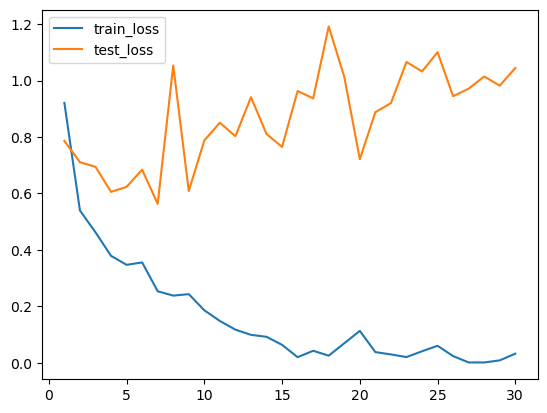

In [14]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

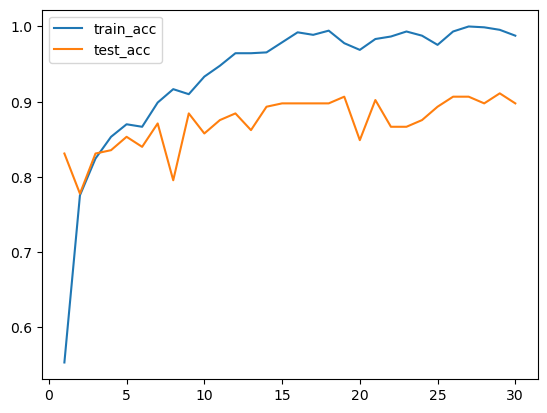

In [15]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()